# Markov Chain for Campaign Attribution POC

In [3]:
import mta
import pandas as pd
import os
import numpy as np
import time
# if you haven't alreadya GCP authenticated run !gcloud auth login
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

Visit http://www.channelattribution.net for more information about ChannelAttribution


Information about MTA module  
https://bitbucket.org/wx_rds/mta/src/50cd3c3f2469/?at=master  
https://bytebucket.org/wx_rds/mta/wiki/_build/latex/mta.pdf?token=ed3f93f21d7e08c5a92ba0abba35888f63412a54&rev=599fd6872540e9a4945b968e0f02a87c9fc15ea5  
https://www.channelattribution.net/assets/files/ChannelAttributionWhitePaper-0536c269c4725179d4a0d8b8ec2f0fac.pdf

## MC POC data

In [4]:
# not working since updated MTA module's conda env
# df_test = pd.read_csv('gs://wx-personal/AndrewLau/chapter/cmd_pivoter/CMD_input.csv')

In [5]:
# alternative to reading from GCP directly into pandas dataframe
# !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/MC_input_with_act_redemp.csv 02_data/MC_input_with_act_redemp.csv
df = pd.read_csv('02_data/MC_input_with_act_redemp.csv')
# !rm 02_data/MC_input_with_act_redemp.csv

In [22]:
# df = df.sample(n=500_000, random_state=123)  # random sample for testing
df.loc[:, "Converted_weighted_constant"] = round(np.maximum(0, df['inc_sales'] + 500), 0)
df.loc[:, "Converted_weighted_constant"] = df.loc[:, "Converted_weighted_constant"].fillna(0).astype("int64")

# rounded
df.loc[:, "Converted_weighted_w_neg"] = round(df['inc_sales'],0 )
df.loc[:, "Converted_weighted_w_neg"] = df.loc[:, "Converted_weighted_w_neg"].fillna(0).astype("int64")


df

wk_start_date                  crn  inc_sales  \
0         2021-02-08  1000000000000000016 -28.388906   
1         2021-02-08  1000000000000000022        NaN   
2         2021-02-08  1000000000000000044        NaN   
3         2021-02-08  1000000000000000048        NaN   
4         2021-02-08  1000000000000000076   7.078295   
...              ...                  ...        ...   
961716    2021-02-08  3300000000004893190        NaN   
961717    2021-02-08  3300000000004893373        NaN   
961718    2021-02-08  3300000000004893716        NaN   
961719    2021-02-08  3300000000004893746        NaN   
961720    2021-02-08  3300000000004894024        NaN   

                                                     path  \
0       CAT-4031_email/social/rapp_activation > CVM-00...   
1                   CAT-4031_email/social/rapp_activation   
2       CAT-4031_email/social/rapp_activation > CAT-41...   
3       CAT-4031_email_open > CAT-4031_email_clk > CAT...   
4       CAT-4105_rw_app_imp > CAT-4105_email/social/ra...   
...                                                   ...   
961716          CVM-3509_rw_app_imp > CAT-4105_rw_app_imp   
961717                                CAT-4105_rw_app_imp   
961718                                CAT-4105_rw_app_imp   
961719                                CAT-4105_rw_app_imp   
961720                                CVM-0007_rw_app_imp   

                                                    Paths  Converted  \
0       start > CAT-4031_email/social/rapp_activation ...          0   
1       start > CAT-4031_email/social/rapp_activation ...          0   
2       start > CAT-4031_email/social/rapp_activation ...          0   
3       start > CAT-4031_email_open > CAT-4031_email_c...          0   
4       start > CAT-4105_rw_app_imp > CAT-4105_email/s...          1   
...                                                   ...        ...   
961716  start > CVM-3509_rw_app_imp > CAT-4105_rw_app_...          0   
961717                 start > CAT-4105_rw_app_imp > null          0   
961718                 start > CAT-4105_rw_app_imp > null          0   
961719                 start > CAT-4105_rw_app_imp > null          0   
961720                 start > CVM-0007_rw_app_imp > null          0   

        Converted_weighted  Converted_weighted_constant  \
0                        0                          472   
1                        0                            0   
2                        0                            0   
3                        0                            0   
4                        7                          507   
...                    ...                          ...   
961716                   0                            0   
961717                   0                            0   
961718                   0                            0   
961719                   0                            0   
961720                   0                            0   

        Converted_weighted_w_neg  
0                            -28  
1                              0  
2                              0  
3                              0  
4                              7  
...                          ...  
961716                         0  
961717                         0  
961718                         0  
961719                         0  
961720                         0  

[961721 rows x 9 columns]

<AxesSubplot:>

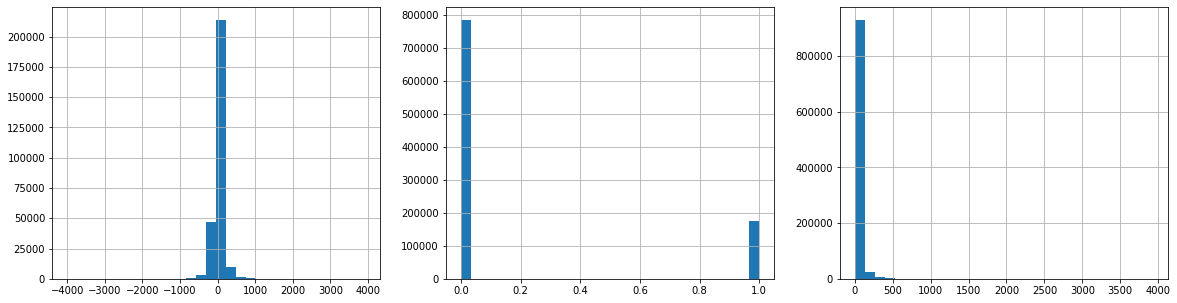

In [7]:
import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
df.inc_sales.hist(figsize=(20,5), bins=30)
# plt.figure()
plt.subplot(1, 3, 2)
df.Converted.hist(bins=30)
# plt.figure()
plt.subplot(1, 3, 3)
df.Converted_weighted.hist(bins=30)

<AxesSubplot:>

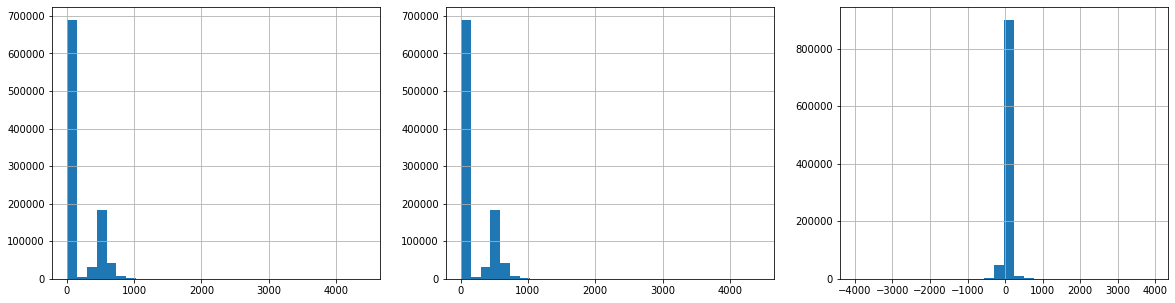

In [23]:
# adding a constant, cupping at 0 and rounding
plt.subplot(1, 3, 1)
df.loc[:, "Converted_weighted_constant"].hist(bins=30, figsize=(20,5))
plt.subplot(1, 3, 2)
# NANs to 0, these are records with no inc sales
df.loc[:, "Converted_weighted_constant"].hist(bins=30)
plt.subplot(1, 3, 3)
# NANs to 0, these are records with no inc sales
df.loc[:, "Converted_weighted_w_neg"].hist(bins=30)

In [9]:
np.percentile(df.inc_sales[df.inc_sales.notna()], 0.05)

-1201.5980878104924

In [24]:
df.head()

wk_start_date                  crn  inc_sales  \
0    2021-02-08  1000000000000000016 -28.388906   
1    2021-02-08  1000000000000000022        NaN   
2    2021-02-08  1000000000000000044        NaN   
3    2021-02-08  1000000000000000048        NaN   
4    2021-02-08  1000000000000000076   7.078295   

                                                path  \
0  CAT-4031_email/social/rapp_activation > CVM-00...   
1              CAT-4031_email/social/rapp_activation   
2  CAT-4031_email/social/rapp_activation > CAT-41...   
3  CAT-4031_email_open > CAT-4031_email_clk > CAT...   
4  CAT-4105_rw_app_imp > CAT-4105_email/social/ra...   

                                               Paths  Converted  \
0  start > CAT-4031_email/social/rapp_activation ...          0   
1  start > CAT-4031_email/social/rapp_activation ...          0   
2  start > CAT-4031_email/social/rapp_activation ...          0   
3  start > CAT-4031_email_open > CAT-4031_email_c...          0   
4  start > CAT-4105_rw_app_imp > CAT-4105_email/s...          1   

   Converted_weighted  Converted_weighted_constant  Converted_weighted_w_neg  
0                   0                          472                       -28  
1                   0                            0                         0  
2                   0                            0                         0  
3                   0                            0                         0  
4                   7                          507                         7

### Planology format

In [11]:
def cj_to_attribution_df_planology(cj, conversion_col, duplicate=False):
    """
    arguments
        cj - dataframe representing customer journey
        conversion_col - column name of conversions, string
        duplicate - if duplications are needed based on conversions > 0, boolean
    returns
        [dataframe with attribution values, total run time, run time of the attribution, shape of customer journey (including dups)]
    """    
    start_time = time.time()
    
    # extract only needed columns
    cj = cj.loc[:, ["crn", "Paths", conversion_col]]    
    
    # duplication for conversion > 0 if needed
    if duplicate:
        cj_dup = pd.DataFrame([cj.loc[idx]
                               for idx in cj.index 
                               for _ in range(cj.loc[idx][conversion_col])]).reset_index(drop=True)
        cj = pd.concat([cj_dup, cj.loc[cj.loc[:, conversion_col] == 0,:]])
    
    # generate attribution
    start_time_mta = time.time()
    attribution_dict = mta.from_journey(cj)    
    
    # ending timers
    run_time_mta = round((time.time() - start_time_mta), 1)
    run_time = round((time.time() - start_time), 1)
    
    # convert to df
    attribution_df = pd.DataFrame.from_dict(attribution_dict, orient='index',columns=["Attribution"]).sort_index()
    
    return [attribution_df, [run_time, run_time_mta], cj.shape]
    

#### Conversion == inc sales > 0

In [12]:
attribution = cj_to_attribution_df_planology(df, "Converted")
attribution

[                                       Attribution
 CAT-4031_email/social/rapp_activation     0.157980
 CAT-4031_email/social/rapp_redemption     0.015345
 CAT-4031_email_clk                        0.011552
 CAT-4031_email_open                       0.067681
 CAT-4031_rw_app_clk                       0.002643
 CAT-4031_rw_app_imp                       0.044424
 CAT-4105_email/social/rapp_activation     0.203452
 CAT-4105_email/social/rapp_redemption     0.147915
 CAT-4105_email_clk                        0.060263
 CAT-4105_email_open                       0.094986
 CAT-4105_rw_app_clk                       0.007576
 CAT-4105_rw_app_imp                       0.058405
 CVM-0007_email/rapp_activation            0.066631
 CVM-0007_email/rapp_redemption            0.031562
 CVM-0007_email_clk                        0.000010
 CVM-0007_email_open                       0.001332
 CVM-0007_rw_app_clk                       0.004502
 CVM-0007_rw_app_imp                       0.020935
 CVM-0007_rw

#### Conversion := positive inc sales dollars

In [13]:
# attribution_weighted = cj_to_attribution_df_planology(df, "Converted_weighted", duplicate=1)
# attribution_weighted

#### Conversion := positive inc sales dollars plus constant

In [14]:
# attribution_weighted_const = cj_to_attribution_df_planology(df, "Converted_weighted_constant", duplicate=1)
# attribution_weighted_const

### Testing new Channel Attribution Format

#### Conversion := inc sales > 0

In [15]:
def convert_to_CA_format(df, conversion_col = "Converted"):
    """
    Massage df into CA format
    arguments
        df - customer journey in planology format
        conversion_col - column name of conversions to be weighted, string
        conversion_col_count - column name of indicator of conversions
    returns
        customer journey in Channel Attribution format, pandas dataframe
    """
    cj_ca = df.loc[:, ["path", conversion_col]]
    cj_ca.loc[:, "conversion_boolean"] = (cj_ca.loc[:, conversion_col] > 0).astype(int)
    cj_ca = cj_ca.groupby("path").agg(['mean', 'count'])

    cj_ca = pd.DataFrame({"path":cj_ca.index,
                          "conversions":cj_ca.loc[:, conversion_col].loc[:, "count"] * cj_ca.loc[:, conversion_col].loc[:, "mean"],
                          "total_conversion_value":cj_ca.loc[:, conversion_col].loc[:, "count"] * cj_ca.loc[:, conversion_col].loc[:, "mean"],
                          "non_conversions":cj_ca.loc[:, "conversion_boolean"].loc[:, "count"] * (1 - cj_ca.loc[:, "conversion_boolean"].loc[:, "mean"])}).reset_index(drop=True)
    cj_ca
    return cj_ca

In [16]:
def cj_to_attribution_df_ca(cj, conversion_col):
    """
    arguments
        cj - dataframe representing customer journey
        conversion_col - column name of conversions, string
        duplicate - if duplications are needed based on conversions > 0, boolean
    returns
        [dataframe with attribution values, total run time, run time of the attribution, shape of customer journey (including dups)]
    """    
    start_time = time.time()
    
    # extract only needed columns
    cj_ca = convert_to_CA_format(cj, conversion_col)    
  
    # generate attribution
    start_time_mta = time.time()
    attribution_dict = mta.ca_from_journey(cj_ca)    
    
    # ending timers
    run_time_mta = round((time.time() - start_time_mta), 1)
    run_time = round((time.time() - start_time), 1)
    
    # convert to df
    attribution_df = attribution_dict.set_index("channel_name").loc[:, ["normalised_conversion_value"]].rename(columns={"normalised_conversion_value":"Attribution_ca"})
    
    return [attribution_df, [run_time, run_time_mta], cj.shape]
    

In [17]:
attribution_ca = cj_to_attribution_df_ca(df, "Converted")

Number of simulations: 100000 - Convergence reached: 4.36% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.99%


In [18]:
attribution_ca_weighted = cj_to_attribution_df_ca(df, "Converted_weighted")

Number of simulations: 100000 - Convergence reached: 1.75% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.69%


In [19]:
attribution_ca_weighted_const = cj_to_attribution_df_ca(df, "Converted_weighted_constant")

Number of simulations: 100000 - Convergence reached: 1.50% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.68%


# Including negatives

In [26]:
convert_to_CA_format(df, "Converted_weighted_w_neg")    

path  conversions  \
0                  CAT-4031_email/social/rapp_activation          0.0   
1      CAT-4031_email/social/rapp_activation > CAT-40...      47199.0   
2      CAT-4031_email/social/rapp_activation > CAT-40...       -136.0   
3      CAT-4031_email/social/rapp_activation > CAT-40...       2188.0   
4      CAT-4031_email/social/rapp_activation > CAT-40...       1147.0   
...                                                  ...          ...   
15196  CVM-3509_rw_app_push_imp > CAT-4105_email/soci...          0.0   
15197  CVM-3509_rw_app_push_imp > CAT-4105_email/soci...          0.0   
15198  CVM-3509_rw_app_push_imp > CAT-4105_rw_app_imp...          0.0   
15199  CVM-3509_rw_app_push_imp > CVM-0007_rw_app_pus...          0.0   
15200     CVM-3509_rw_app_push_imp > CVM-3509_rw_app_imp          0.0   

       total_conversion_value  non_conversions  
0                         0.0         129944.0  
1                     47199.0           1624.0  
2                      -136.0              1.0  
3                      2188.0            401.0  
4                      1147.0             53.0  
...                       ...              ...  
15196                     0.0              1.0  
15197                     0.0              1.0  
15198                     0.0              1.0  
15199                     0.0              1.0  
15200                     0.0              1.0  

[15201 rows x 4 columns]

In [28]:
conversion_col = "Converted_weighted_w_neg"
cj_ca = df.loc[:, ["path", conversion_col]]
cj_ca.loc[:, "conversion_boolean"] = (cj_ca.loc[:, conversion_col] > 0).astype(int)
cj_ca = cj_ca.groupby("path").agg(['mean', 'count'])

cj_ca = pd.DataFrame({"path":cj_ca.index,
                      "conversions":cj_ca.loc[:, "conversion_boolean"].loc[:, "count"] * (cj_ca.loc[:, "conversion_boolean"].loc[:, "mean"]),
                      "total_conversion_value":cj_ca.loc[:, conversion_col].loc[:, "count"] * cj_ca.loc[:, conversion_col].loc[:, "mean"],
                      "non_conversions":cj_ca.loc[:, "conversion_boolean"].loc[:, "count"] * (1 - cj_ca.loc[:, "conversion_boolean"].loc[:, "mean"])}).reset_index(drop=True)
cj_ca

path  conversions  \
0                  CAT-4031_email/social/rapp_activation          0.0   
1      CAT-4031_email/social/rapp_activation > CAT-40...       2180.0   
2      CAT-4031_email/social/rapp_activation > CAT-40...          0.0   
3      CAT-4031_email/social/rapp_activation > CAT-40...        516.0   
4      CAT-4031_email/social/rapp_activation > CAT-40...         87.0   
...                                                  ...          ...   
15196  CVM-3509_rw_app_push_imp > CAT-4105_email/soci...          0.0   
15197  CVM-3509_rw_app_push_imp > CAT-4105_email/soci...          0.0   
15198  CVM-3509_rw_app_push_imp > CAT-4105_rw_app_imp...          0.0   
15199  CVM-3509_rw_app_push_imp > CVM-0007_rw_app_pus...          0.0   
15200     CVM-3509_rw_app_push_imp > CVM-3509_rw_app_imp          0.0   

       total_conversion_value  non_conversions  
0                         0.0         129944.0  
1                     47199.0           1624.0  
2                      -136.0              1.0  
3                      2188.0            401.0  
4                      1147.0             53.0  
...                       ...              ...  
15196                     0.0              1.0  
15197                     0.0              1.0  
15198                     0.0              1.0  
15199                     0.0              1.0  
15200                     0.0              1.0  

[15201 rows x 4 columns]

In [30]:
mta.ca_from_journey(cj_ca)    

Number of simulations: 100000 - Convergence reached: 4.44% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.99%


channel_name  total_conversions  \
0   CAT-4031_email/social/rapp_activation       28248.604727   
1   CAT-4031_email/social/rapp_redemption        2586.424467   
2                      CAT-4031_email_clk        2061.056997   
3                     CAT-4031_email_open       12083.451807   
4                     CAT-4031_rw_app_imp        7516.796108   
5   CAT-4105_email/social/rapp_activation       35118.794717   
6   CAT-4105_email/social/rapp_redemption       24975.161260   
7                     CAT-4105_email_open       17135.062095   
8                      CAT-4105_email_clk       10911.478221   
9                     CAT-4105_rw_app_imp        9739.504634   
10                    CAT-4105_rw_app_clk        1374.037998   
11                    CVM-0007_email_open         161.651529   
12                    CAT-4031_rw_app_clk         404.128823   
13                    CVM-0007_rw_app_imp        3394.682113   
14                    CVM-3509_rw_app_imp         363.715941   
15                    CVM-3509_email_open          80.825765   
16                    CVM-3509_rw_app_clk           0.000000   
17                    CVM-0007_rw_app_clk         646.606117   
18               CVM-3509_rw_app_push_clk          40.412882   
19         CVM-0007_email/rapp_activation       11679.322984   
20         CVM-0007_email/rapp_redemption        5859.867933   
21               CVM-0007_rw_app_push_clk          40.412882   
22               CVM-0007_rw_app_push_imp           0.000000   
23                     CVM-0007_email_clk           0.000000   
24                     CVM-3509_email_clk           0.000000   
25               CVM-3509_rw_app_push_imp           0.000000   

    total_conversion_value  normalised_conversion_value  
0             1.075652e+06                     0.156062  
1             7.578823e+04                     0.010996  
2             8.822564e+04                     0.012800  
3             4.264348e+05                     0.061870  
4             3.052683e+05                     0.044290  
5             1.462912e+06                     0.212247  
6             1.112548e+06                     0.161415  
7             7.622056e+05                     0.110585  
8             4.913996e+05                     0.071295  
9             3.999641e+05                     0.058029  
10            3.622271e+04                     0.005255  
11            6.230911e+03                     0.000904  
12            1.255403e+04                     0.001821  
13            7.450235e+04                     0.010809  
14            2.308382e+04                     0.003349  
15           -2.590359e+02                    -0.000038  
16            0.000000e+00                     0.000000  
17            2.379934e+04                     0.003453  
18            2.800710e+03                     0.000406  
19            2.910844e+05                     0.042232  
20            2.197679e+05                     0.031885  
21            2.301954e+03                     0.000334  
22            0.000000e+00                     0.000000  
23            0.000000e+00                     0.000000  
24            0.000000e+00                     0.000000  
25            0.000000e+00                     0.000000

# Results

In [21]:
# uncomment if planology dup
# results = attribution[0].join(attribution_weighted[0], lsuffix='', rsuffix='_weighted').join(attribution_weighted_const[0], lsuffix='', rsuffix='_weighted_const')
# results = results.join(attribution_ca[0], lsuffix='', rsuffix='_ca').join(attribution_ca_weighted[0], lsuffix='', rsuffix='_ca_weighted').join(attribution_ca_weighted_const[0], lsuffix='', rsuffix='_ca_weighted_const')

# uncomment if no planology dup
results = attribution[0].join(attribution_ca[0]).join(attribution_ca_weighted[0], rsuffix='_weighted').join(attribution_ca_weighted_const[0], rsuffix='_weighted_const')

results.loc['Column_Total']= results.sum(numeric_only=True, axis=0)
results

Attribution  Attribution_ca  \
CAT-4031_email/social/rapp_activation     0.157980        0.160964   
CAT-4031_email/social/rapp_redemption     0.015345        0.014255   
CAT-4031_email_clk                        0.011552        0.011957   
CAT-4031_email_open                       0.067681        0.068993   
CAT-4031_rw_app_clk                       0.002643        0.002299   
CAT-4031_rw_app_imp                       0.044424        0.043224   
CAT-4105_email/social/rapp_activation     0.203452        0.201206   
CAT-4105_email/social/rapp_redemption     0.147915        0.143017   
CAT-4105_email_clk                        0.060263        0.062078   
CAT-4105_email_open                       0.094986        0.098184   
CAT-4105_rw_app_clk                       0.007576        0.007587   
CAT-4105_rw_app_imp                       0.058405        0.055637   
CVM-0007_email/rapp_activation            0.066631        0.067828   
CVM-0007_email/rapp_redemption            0.031562        0.034722   
CVM-0007_email_clk                        0.000010        0.000000   
CVM-0007_email_open                       0.001332        0.000920   
CVM-0007_rw_app_clk                       0.004502        0.004140   
CVM-0007_rw_app_imp                       0.020935        0.020002   
CVM-0007_rw_app_push_clk                  0.000156        0.000230   
CVM-0007_rw_app_push_imp                  0.000006        0.000000   
CVM-3509_email_clk                        0.000007        0.000000   
CVM-3509_email_open                       0.000492        0.000690   
CVM-3509_rw_app_clk                       0.000131        0.000000   
CVM-3509_rw_app_imp                       0.001930        0.002069   
CVM-3509_rw_app_push_clk                  0.000078        0.000000   
CVM-3509_rw_app_push_imp                  0.000003        0.000000   
Column_Total                              1.000000        1.000000   

                                       Attribution_ca_weighted  \
CAT-4031_email/social/rapp_activation                 0.155508   
CAT-4031_email/social/rapp_redemption                 0.026357   
CAT-4031_email_clk                                    0.009774   
CAT-4031_email_open                                   0.053154   
CAT-4031_rw_app_clk                                   0.001794   
CAT-4031_rw_app_imp                                   0.039975   
CAT-4105_email/social/rapp_activation                 0.184354   
CAT-4105_email/social/rapp_redemption                 0.172859   
CAT-4105_email_clk                                    0.054472   
CAT-4105_email_open                                   0.082256   
CAT-4105_rw_app_clk                                   0.007724   
CAT-4105_rw_app_imp                                   0.057913   
CVM-0007_email/rapp_activation                        0.076509   
CVM-0007_email/rapp_redemption                        0.052531   
CVM-0007_email_clk                                    0.000037   
CVM-0007_email_open                                   0.000879   
CVM-0007_rw_app_clk                                   0.003478   
CVM-0007_rw_app_imp                                   0.018340   
CVM-0007_rw_app_push_clk                              0.000073   
CVM-0007_rw_app_push_imp                              0.000000   
CVM-3509_email_clk                                    0.000000   
CVM-3509_email_open                                   0.000476   
CVM-3509_rw_app_clk                                   0.000073   
CVM-3509_rw_app_imp                                   0.001428   
CVM-3509_rw_app_push_clk                              0.000037   
CVM-3509_rw_app_push_imp                              0.000000   
Column_Total                                          1.000000   

                                       Attribution_ca_weighted_const  
CAT-4031_email/social/rapp_activation                       0.155075  
CAT-4031_email/social/rapp_redemption                       0.028980  
CAT-4031_email_c

# Speed testing

In [46]:
# df = pd.read_csv('gs://wx-personal/AndrewLau/nash/MC_POC/MC_input.csv')
# if GCP isn't working
df = pd.read_csv('02_data/MC_input_with_act_redemp.csv')

# df = df.sample(n=500_000, random_state=123)  # random sample for testing
df.loc[:, "Converted_weighted_constant"] = round(np.maximum(0, df['inc_sales'] + 500), 0)
df.loc[:, "Converted_weighted_constant"] = df.loc[:, "Converted_weighted_constant"].fillna(0).astype("int64")
df

wk_start_date                  crn  inc_sales  \
0         2021-02-08  1000000000000000016 -28.388906   
1         2021-02-08  1000000000000000022        NaN   
2         2021-02-08  1000000000000000044        NaN   
3         2021-02-08  1000000000000000048        NaN   
4         2021-02-08  1000000000000000076   7.078295   
...              ...                  ...        ...   
961716    2021-02-08  3300000000004893190        NaN   
961717    2021-02-08  3300000000004893373        NaN   
961718    2021-02-08  3300000000004893716        NaN   
961719    2021-02-08  3300000000004893746        NaN   
961720    2021-02-08  3300000000004894024        NaN   

                                                     path  \
0       CAT-4031_email/social/rapp_activation > CVM-00...   
1                   CAT-4031_email/social/rapp_activation   
2       CAT-4031_email/social/rapp_activation > CAT-41...   
3       CAT-4031_email_open > CAT-4031_email_clk > CAT...   
4       CAT-4105_rw_app_imp > CAT-4105_email/social/ra...   
...                                                   ...   
961716          CVM-3509_rw_app_imp > CAT-4105_rw_app_imp   
961717                                CAT-4105_rw_app_imp   
961718                                CAT-4105_rw_app_imp   
961719                                CAT-4105_rw_app_imp   
961720                                CVM-0007_rw_app_imp   

                                                    Paths  Converted  \
0       start > CAT-4031_email/social/rapp_activation ...          0   
1       start > CAT-4031_email/social/rapp_activation ...          0   
2       start > CAT-4031_email/social/rapp_activation ...          0   
3       start > CAT-4031_email_open > CAT-4031_email_c...          0   
4       start > CAT-4105_rw_app_imp > CAT-4105_email/s...          1   
...                                                   ...        ...   
961716  start > CVM-3509_rw_app_imp > CAT-4105_rw_app_...          0   
961717                 start > CAT-4105_rw_app_imp > null          0   
961718                 start > CAT-4105_rw_app_imp > null          0   
961719                 start > CAT-4105_rw_app_imp > null          0   
961720                 start > CVM-0007_rw_app_imp > null          0   

        Converted_weighted  Converted_weighted_constant  
0                        0                          472  
1                        0                            0  
2                        0                            0  
3                        0                            0  
4                        7                          507  
...                    ...                          ...  
961716                   0                            0  
961717                   0                            0  
961718                   0                            0  
961719                   0                            0  
961720                   0                            0  

[961721 rows x 8 columns]

In [47]:
def speed_test(df, samples, seed=123, planology_dup=False):
    df = df.sample(n=samples, random_state=seed)  # random sample for testing
    
    if planology_dup:
        attribution_weighted = cj_to_attribution_df_planology(df, "Converted_weighted", duplicate=1)
        attribution_weighted_const = cj_to_attribution_df_planology(df, "Converted_weighted_constant", duplicate=1)

    attribution = cj_to_attribution_df_planology(df, "Converted")
    attribution_ca = cj_to_attribution_df_ca(df, "Converted")
    attribution_ca_weighted = cj_to_attribution_df_ca(df, "Converted_weighted")
    attribution_ca_weighted_const = cj_to_attribution_df_ca(df, "Converted_weighted_constant")
    
    if planology_dup:
        return pd.DataFrame({"index":["Runtime total, runtime MTA", "Dataframe shape"], "Planology": attribution[1:]
                             , "Planology weighted": attribution_weighted[1:], "Planology weighted constant": attribution_weighted_const[1:]
                             , "CA": attribution_ca[1:], "CA weighted": attribution_ca_weighted[1:], "CA weighted constant": attribution_ca_weighted_const[1:]
                            }).set_index("index")
    else:
        return pd.DataFrame({"index":["Runtime total, runtime MTA", "Dataframe shape"], "Planology": attribution[1:]
                             , "CA": attribution_ca[1:], "CA weighted": attribution_ca_weighted[1:], "CA weighted constant": attribution_ca_weighted_const[1:]
                            }).set_index("index")

In [48]:
results_speed_1k = speed_test(df, 1_000, planology_dup=True)

Number of simulations: 100000 - Convergence reached: 4.48% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.96%
Number of simulations: 100000 - Convergence reached: 1.46% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.49%
Number of simulations: 100000 - Convergence reached: 1.68% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.16%


In [49]:
results_speed_5k = speed_test(df, 5_000, planology_dup=True)

Number of simulations: 100000 - Convergence reached: 4.36% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.96%
Number of simulations: 100000 - Convergence reached: 1.83% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.42%
Number of simulations: 100000 - Convergence reached: 1.70% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.25%


In [58]:
results_speed_10k = speed_test(df, 10_000, planology_dup=True)

Number of simulations: 100000 - Convergence reached: 4.39% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.97%
Number of simulations: 100000 - Convergence reached: 1.79% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.44%
Number of simulations: 100000 - Convergence reached: 1.50% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.30%


In [59]:
results_speed_25k = speed_test(df, 25_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.76% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.97%
Number of simulations: 100000 - Convergence reached: 2.09% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.34%
Number of simulations: 100000 - Convergence reached: 1.63% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.34%


In [60]:
results_speed_50k = speed_test(df, 50_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.86% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.97%
Number of simulations: 100000 - Convergence reached: 1.96% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.35%
Number of simulations: 100000 - Convergence reached: 1.78% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.33%


In [61]:
results_speed_100k = speed_test(df, 100_000, planology_dup=False)

Number of simulations: 100000 - Reaching convergence (wait...): 5.73% > 5.00%
Number of simulations: 150000 - Convergence reached: 4.88% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.65% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.57%
Number of simulations: 100000 - Convergence reached: 1.42% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.54%


In [62]:
results_speed_250k = speed_test(df, 250_000, planology_dup=False)

Number of simulations: 100000 - Reaching convergence (wait...): 5.67% > 5.00%
Number of simulations: 150000 - Convergence reached: 4.95% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.56% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.53%
Number of simulations: 100000 - Convergence reached: 1.85% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.50%


In [63]:
results_speed_500k = speed_test(df, 500_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.13% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.81% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.54%
Number of simulations: 100000 - Convergence reached: 1.75% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.56%


In [64]:
results_speed_750k = speed_test(df, 750_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.16% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.65% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.72%
Number of simulations: 100000 - Convergence reached: 1.98% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.70%


In [65]:
results_speed_1k.append(results_speed_5k).append(results_speed_10k).append(results_speed_25k).append(results_speed_50k).append(results_speed_100k).append(results_speed_250k).append(results_speed_500k).append(results_speed_750k)

Planology Planology weighted  \
index                                                           
Runtime total, runtime MTA      [0.8, 0.8]         [6.5, 3.7]   
Dataframe shape                  (1000, 3)         (14174, 3)   
Runtime total, runtime MTA      [2.0, 2.0]       [37.9, 22.1]   
Dataframe shape                  (5000, 3)         (80660, 3)   
Runtime total, runtime MTA      [3.8, 3.8]       [78.2, 46.4]   
Dataframe shape                 (10000, 3)        (159288, 3)   
Runtime total, runtime MTA      [8.5, 8.5]                NaN   
Dataframe shape                 (25000, 3)                NaN   
Runtime total, runtime MTA    [17.3, 17.3]                NaN   
Dataframe shape                 (50000, 3)                NaN   
Runtime total, runtime MTA    [36.6, 36.6]                NaN   
Dataframe shape                (100000, 3)                NaN   
Runtime total, runtime MTA    [92.9, 92.9]                NaN   
Dataframe shape                (250000, 3)                NaN   
Runtime total, runtime MTA  [184.3, 184.3]                NaN   
Dataframe shape                (500000, 3)                NaN   
Runtime total, runtime MTA  [281.5, 281.5]                NaN   
Dataframe shape                (750000, 3)                NaN   

                           Planology weighted constant           CA  \
index                                                                 
Runtime total, runtime MTA                [60.6, 32.1]   [0.1, 0.0]   
Dataframe shape                            (142281, 3)    (1000, 8)   
Runtime total, runtime MTA              [346.4, 198.0]   [0.1, 0.0]   
Dataframe shape                            (761355, 3)    (5000, 8)   
Runtime total, runtime MTA              [738.4, 434.1]   [0.1, 0.1]   
Dataframe shape                           (1554313, 3)   (10000, 8)   
Runtime total, runtime MTA                         NaN   [0.1, 0.1]   
Dataframe shape                                    NaN   (25000, 8)   
Runtime total, runtime MTA                         NaN   [0.2, 0.1]   
Dataframe shape                                    NaN   (50000, 8)   
Runtime total, runtime MTA                         NaN   [0.2, 0.1]   
Dataframe shape                                    NaN  (100000, 8)   
Runtime total, runtime MTA                         NaN   [0.3, 0.2]   
Dataframe shape                                    NaN  (250000, 8)   
Runtime total, runtime MTA                         NaN   [0.4, 0.1]   
Dataframe shape                                    NaN  (500000, 8)   
Runtime total, runtime MTA                         NaN   [0.4, 0.1]   
Dataframe shape                                    NaN  (750000, 8)   

                            CA weighted CA weighted constant  
index                                                         
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape               (1000, 8)            (1000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape               (5000, 8)            (5000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape              (10000, 8)           (10000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape              (25000, 8)           (25000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape              (50000, 8)           (50000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape             (100000, 8)          (100000, 8)  
Runtime total, runtime MTA   [0.2, 0.1]           [0.2, 0.1]  
Dataframe shape             (250000, 8)          (250000, 8)  
Runtime total, runtime MTA   [0.3, 0.1]           [0.3, 0.1]  
Dataframe shape             (500000, 8)          (500000, 8)  
Runtime total, runtime MTA   [0.4, 0.2]           [0.4, 0.2]  
Dataframe shape             (750000, 8)          (750000, 8)